## Computation Tools for Data Science - Group 6

**Group members:**
- Raquel Chaves Martinez - s243297
- Paula Gambus i Moreno - s233219
- Angel Paisan Garcia - s232793
- Alba Pi Mas - s243280

### Library importation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import functions as f

import string
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import ast
from tqdm import tqdm
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
import warnings

## Building and exploring the dataset

**NOTE:** The result of the merge of the datasets and calculation of the sentiment can be found in *main_complete.csv*. We recommend not rerunning the code used to generating the file because the computations involved are highly resource-intensive, resulting in long execution times.

First, we open all the datasets that we are going to get information from.

In [2]:
netflix = pd.read_csv('data/netflix.csv')
amazon = pd.read_csv('data/amazon.csv')
hulu = pd.read_csv('data/hulu.csv')
apple = pd.read_csv('data/apple.csv')
hbo = pd.read_csv('data/hbo.csv')

main = pd.read_csv('data/TMDB_all_movies.csv')

Since we only want to do movie recommendation, we remove all the entries that are not classified as movies in the platform datasets.

In [3]:
print('Before removing shows')
print(netflix.shape)
print(amazon.shape)
print(hulu.shape)
print(apple.shape)
print(hbo.shape)

netflix = f.remove_tv_show(netflix)
apple = f.remove_tv_show(apple)
hulu = f.remove_tv_show(hulu)
amazon = f.remove_tv_show(amazon)
hbo = f.remove_tv_show(hbo)

#dimension of the dataset
print('After removing shows')
print(netflix.shape)
print(amazon.shape)
print(hulu.shape)
print(apple.shape)
print(hbo.shape)

Before removing shows
(20106, 8)
(66905, 8)
(9753, 8)
(17648, 8)
(7017, 8)
After removing shows
(15499, 8)
(58559, 8)
(5915, 8)
(13598, 8)
(3653, 8)


Once we have the auxiliar datasets clean, we can merge it with the main dataset. To do it, we have built a function that can be found in *function.py* . This function takes the platform dataset and the main dataset and adds a new binary column where the 0 indicates that the movie is not in the platform and the 1 represents that the movie is in the platform.

In [4]:
main_netflix = f.platform_column(main, netflix, 'Netflix')
main_net_ama = f.platform_column(main_netflix, amazon, 'Amazon')
main_net_ama_hulu = f.platform_column(main_net_ama, hulu, 'Hulu')
main_net_ama_hulu_apple = f.platform_column(main_net_ama_hulu, apple, 'Apple')
main_complete = f.platform_column(main_net_ama_hulu_apple, hbo, 'HBO')


To see the amount of movies that we have in each platform:

In [5]:
netflix_count = f.count_movies(main_complete, 'Netflix')
print('Movies in Netflix:', netflix_count)
amazon_count = f.count_movies(main_complete, 'Amazon')
print('Movies in Amazon prime:', amazon_count)
hulu_count = f.count_movies(main_complete, 'Hulu')
print('Movies in Hulu:', hulu_count)
apple_count = f.count_movies(main_complete, 'Apple')
print('Movies in Apple TV:', apple_count)
hbo_count = f.count_movies(main_complete, 'HBO')
print('Movies in HBO Max:', hbo_count)

Movies in Netflix: 36998.0
Movies in Amazon prime: 108669.0
Movies in Hulu: 15330.0
Movies in Apple TV: 32572.0
Movies in HBO Max: 10606.0


Once we have all the information in the same dataframe, we can start applying methods. First, we will calculate the sentiment of the overview of the movies.

## Calculation of the sentiment

First, we will do some exploration of the overview.

In [7]:
main_complete['overview']

0          After the coal mine he works at closes and his...
1          Nikander, a rubbish collector and would-be ent...
2          It's Ted the Bellhop's first night on the job....
3          Four young friends, while taking a shortcut en...
4          Timo Novotny labels his new project an experim...
                                 ...                        
1009834    “Hommage à Beksinski” is a short film commissi...
1009835                                                  NaN
1009836                                                  NaN
1009837                                                  NaN
1009838                                                  NaN
Name: overview, Length: 1009839, dtype: object

As it can be seen, there are some missing values in the overview (description of the movie). When we calculate the sentiment, the movies that don't have an overview will be assigned Nan and not 0, because a sentiment of 0 denotes sadness (the lower the score, the sadder is the description/movie).

We have built a sentiment function that takes a list of tokens and calculates the sentiment based on the LabMT wordlist. This function is called by a fucntion named *preprocess_and_analyze_sentiment*, which takes the text and returns the sentiment score.

In [8]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
punctuation_table = str.maketrans('', '', string.punctuation)

In [9]:
main_complete['sentiment'] = main_complete['overview'].apply(f.preprocess_and_analyze_sentiment)

In [ ]:
#save the main_complete dataset
#main_complete.to_csv('data/main_complete.csv', index=False)

## Exploration of the dataset to calculate similarity

After merging the movies dataset with the platforms dataset and adding the sentiment score columnd we saved the resulting dataset ('main_complete') to avoid generating it every time. Here, we load the dataset and continue working.

In [3]:
main_complete = pd.read_csv('data/main_complete.csv')
main_complete.head()

,id,title,vote_average,vote_count,status,release_date,revenue,runtime,budget,imdb_id,...,music_composer,imdb_rating,imdb_votes,poster_path,Netflix,Amazon,Hulu,Apple,HBO,sentiment
0,2,Ariel,7.1,330.0,Released,1988-10-21,0.0,73.0,0.0,tt0094675,...,NaN,7.4,8735.0,/ojDg0PGvs6R9xYFodRct2kdI6wC.jpg,0.0,1.0,1.0,0.0,0.0,68.24
1,3,Shadows in Paradise,7.3,369.0,Released,1986-10-17,0.0,74.0,0.0,tt0092149,...,NaN,7.5,7484.0,/nj01hspawPof0mJmlgfjuLyJuRN.jpg,0.0,1.0,1.0,0.0,0.0,73.44
2,5,Four Rooms,5.8,2623.0,Released,1995-12-09,4257354.0,98.0,4000000.0,tt0113101,...,Combustible Edison,6.7,112484.0,/75aHn1NOYXh4M7L5shoeQ6NGykP.jpg,0.0,1.0,0.0,1.0,0.0,86.06
3,6,Judgment Night,6.5,331.0,Released,1993-10-15,12136938.0,109.0,21000000.0,tt0107286,...,Alan Silvestri,6.6,19268.0,/3rvvpS9YPM5HB2f4HYiNiJVtdam.jpg,0.0,1.0,0.0,0.0,0.0,79.34
4,8,Life in Loops (A Megacities RMX),7.5,27.0,Released,2006-01-01,0.0,80.0,42000.0,tt0825671,...,NaN,8.2,284.0,/7ln81BRnPR2wqxuITZxEciCe1lc.jpg,0.0,0.0,0.0,0.0,0.0,382.44


To calculate the similarity, we need to do minhashing, that is why, a tokenization is first needed. We wanted to take several features for calculating the jaccard similarity:
- genre
- cast
- crew
- sentiment
- platforms (one-hot encoded)
- crew
- production companies
- production countries
- imbd votes
- imbd rating

To tokenize the features, we created sets for each of them with all the strings of each category inside

### Genres

In [4]:
# check how many movies have no genre
nulls = main_complete['genres'].isnull().sum()
print("This percentage of movies have no genre:", nulls/len(main_complete)*100, "%")

This percentage of movies have no genre: 29.076318106153554 %


In [5]:
# split the genres into a set of genres and remove spaces
main_complete['genres'] = main_complete['genres'].apply(lambda x: set(genre.strip() for genre in x.split(',')) if pd.notnull(x) else set())

We will also do a small analysis of the genres to learn more about the data

There are  19 different genres in the dataset
The genres are: {'Fantasy', 'War', 'TV Movie', 'Romance', 'Music', 'History', 'Horror', 'Action', 'Thriller', 'Adventure', 'Crime', 'Mystery', 'Family', 'Comedy', 'Animation', 'Documentary', 'Western', 'Science Fiction', 'Drama'}


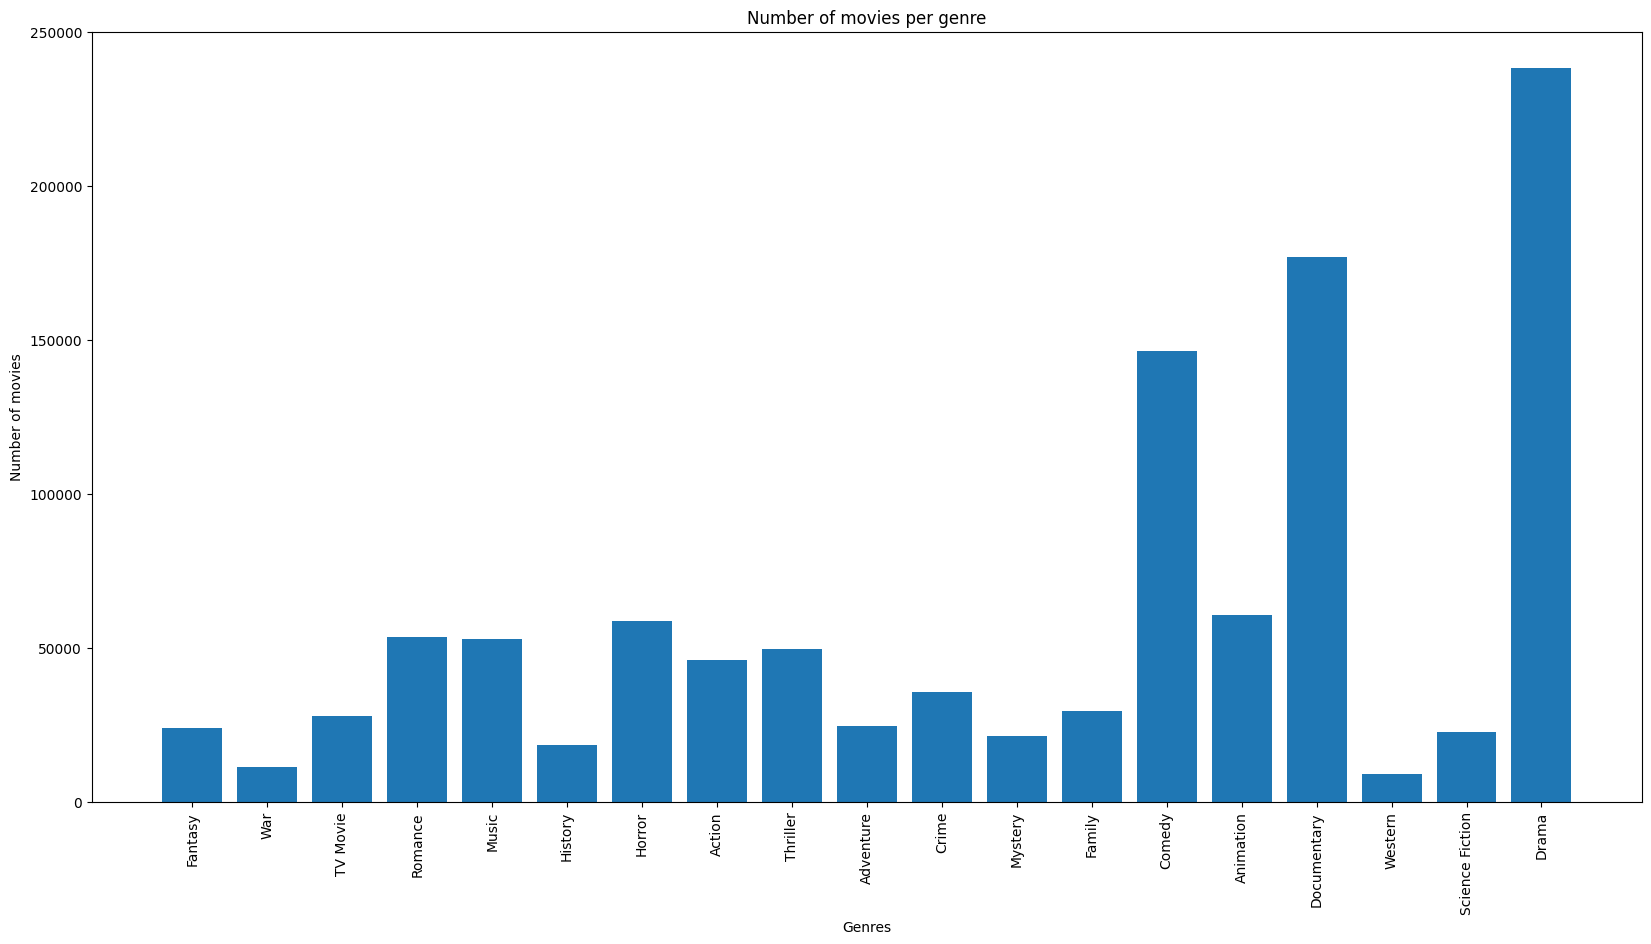

In [6]:
# check how many different genres are taking into account the content of the lists
genres = set()
for list in main_complete['genres']:
    # if list is not NaN
    if list is not np.nan:
        for genre in list:
            # remove the space at the beginning of the string if there is one
            genre = genre.strip()
            genres.add(genre)
print("There are ", len(genres), "different genres in the dataset")
print("The genres are:", genres)

genres_count = {genre: 0 for genre in genres}
for genre_list in main_complete['genres']:
    if genre_list is not np.nan:
        for genre in genre_list:
            genre = genre.strip()
            genres_count[genre] += 1

# histogram
plt.figure(figsize=(20, 10))
plt.bar(genres_count.keys(), genres_count.values())
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Number of movies')
plt.title('Number of movies per genre')
plt.show()

### Cast and crew

We will know follow the same procedure with the cast and the crew. Moreover, for the crew we will join the columns of director and producers.

#### Cast

In [7]:
# split the cast into a set of cast and remove spaces
main_complete['cast'] = main_complete['cast'].apply(lambda x: set(actor.strip() for actor in x.split(',')) if pd.notnull(x) else set())

In [8]:
# how many movies have no cast
nulls = main_complete['cast'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no cast:", nulls/len(main_complete)*100, "%")

print(nulls)

This percentage of movies have no cast: 33.29124741666741 %
336188


**NOTE:** After doing several tests with the code using different features, we decided to discard the 'cast'. We took this decision based on its length, since it is usally long it has a big weight when calculating the similarities.

In [9]:
# remove the cast column
main_complete = main_complete.drop(columns=['cast'])

#### Crew

In [10]:
# Join the director and producers columns into a single column crew
columns_to_merge = ['director', 'producers']

for column in columns_to_merge:
    main_complete[column] = main_complete[column].apply(lambda x: set(person.strip() for person in x.split(',')) if pd.notnull(x) else set())

main_complete['crew'] = main_complete.apply(lambda row: set.union(row['director'], row['producers']), axis=1)

# Drop the individual columns
main_complete.drop(columns=columns_to_merge, inplace=True)

In [11]:
# how many movies have no crew
nulls = main_complete['crew'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no crew:", nulls/len(main_complete)*100, "%")

This percentage of movies have no crew: 17.2818637426362 %


### Production companies and countries

The same procedure was also followed with these two features

In [12]:
# split the production_companies into a set and remove spaces
main_complete['production_companies'] = main_complete['production_companies'].apply(lambda x: set(company.strip() for company in x.split(',')) if pd.notnull(x) else set())
main_complete['production_companies'] = main_complete['production_companies'].apply(lambda x: x - {''})


In [13]:
# percentage of movies with no production companies
nulls = main_complete['production_companies'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no production companies:", nulls/len(main_complete)*100, "%")

This percentage of movies have no production companies: 53.91235632610743 %


In [14]:
main_complete['production_countries'] = main_complete['production_countries'].apply(lambda x: set(country.strip() for country in x.split(',')) if pd.notnull(x) else set())
main_complete['production_countries'] = main_complete['production_countries'].apply(lambda x: x - {''})

In [15]:
# percentage of movies with no production countries
nulls = main_complete['production_countries'].apply(lambda x: len(x) == 0).sum()
print("This percentage of movies have no production countries:", nulls/len(main_complete)*100, "%")

This percentage of movies have no production countries: 39.518774774988884 %


### Sentiment

To take into account the sentiment of the movie description, we decided to create three categories depending on the values.

To find the thresholds we calculated the mean and the standard deviation of the sentiment and we classified those further away from the mean than the standard deviation on the low end as low, those within the standard deviation as medium and those further away from the mean than the standard deviation on the high end as high. 

In [4]:
sentiment_min = main_complete['sentiment'].min()
sentiment_max = main_complete['sentiment'].max()
sentiment_mean = main_complete['sentiment'].mean()
sentiment_std = main_complete['sentiment'].std()
sentiment_mid = main_complete['sentiment'].median()

print(f"Range of sentiment values: {sentiment_min} to {sentiment_max} with mean {sentiment_mean} and standard deviation {sentiment_std} and median {sentiment_mid}")

Range of sentiment values: 0.0 to 621.52 with mean 109.39746533773106 and standard deviation 83.97651422418457 and median 85.76


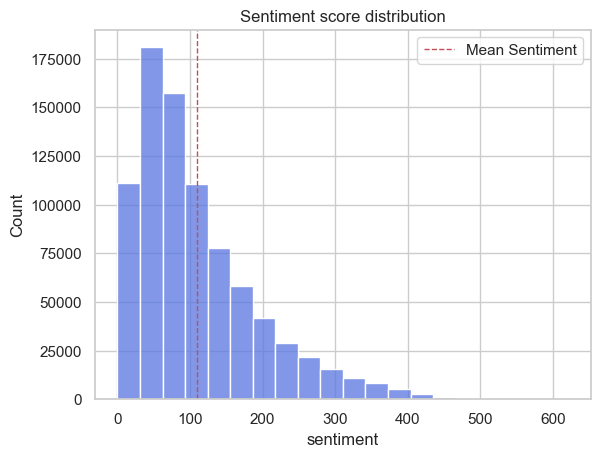

In [6]:
sns.set_theme(style="whitegrid")

sns.histplot(data=main_complete, x='sentiment', bins=20, color='#5875E1', kde=False)
plt.axvline(main_complete['sentiment'].mean(), color='r', linestyle='dashed', linewidth=1, label='Mean Sentiment')
plt.title('Sentiment score distribution')
plt.legend()
plt.show()

In [19]:
# Define the thresholds for sentiment ranges
low_threshold = sentiment_mean - sentiment_std
high_threshold = sentiment_mean + sentiment_std

# Function to categorize sentiment
def categorize_sentiment(value):
    if value < low_threshold:
        return 'low'
    elif value > high_threshold:
        return 'high'
    else:
        return 'medium'

# Assuming main_complete is already defined and categorize_sentiment is a function
main_complete.loc[:, 'sentiment_category'] = main_complete['sentiment'].apply(categorize_sentiment)

# Display the updated dataframe
main_complete[['title', 'sentiment', 'sentiment_category']].head()

,title,sentiment,sentiment_category
0,Ariel,68.24,medium
1,Shadows in Paradise,73.44,medium
2,Four Rooms,86.06,medium
3,Judgment Night,79.34,medium
4,Life in Loops (A Megacities RMX),382.44,high


### Dataset cleaning

Before doing the minhashing, we will remove the movies that were not 'Released' or have more than four of the features that we are interested in empty.

In [20]:
# clean movies with 4 or more interesting columns empty
columns = ['genres', 'crew', 'production_companies', 'production_countries', 'sentiment_category']

initial_count = len(main_complete)

# check each row if they have 3 or more columns from columns with empty sets
main_complete = main_complete[~(main_complete[columns].apply(lambda x: sum(1 for i in x if len(i) == 0) >= 4, axis=1))]
final_count = len(main_complete)

print("Number of movies removed: ", initial_count - final_count, "from a total of ", initial_count)
print("Percentage of movies removed: ", (initial_count - final_count) / initial_count * 100, "%")

Number of movies removed:  94569 from a total of  1009839
Percentage of movies removed:  9.364760125128857 %


In [21]:
# remove movies if the 'status' is not 'Released'
initial_count = len(main_complete)
main_complete = main_complete[main_complete['status'] == 'Released']
final_count = len(main_complete)

print("Number of movies removed: ", initial_count - final_count, "from a total of ", initial_count)
print("Percentage of movies removed: ", (initial_count - final_count) / initial_count * 100, "%")

Number of movies removed:  15995 from a total of  915270
Percentage of movies removed:  1.7475717547827416 %


## Minhasing

Since we are not going to work with all the features, we will first prepare the dataset to only choose the variables needed.

In [22]:
data = main_complete[['id', 'title', 'genres', 'sentiment_category', 'Netflix', 'Amazon', 'Hulu', 'Apple', 'HBO', 'crew', 'production_companies', 'production_countries', 'imdb_votes', 'imdb_rating']]

In [23]:
data.head()

,id,title,genres,sentiment_category,Netflix,Amazon,Hulu,Apple,HBO,crew,production_companies,production_countries,imdb_votes,imdb_rating
0,2,Ariel,"{Drama, Crime, Comedy, Romance}",medium,0.0,1.0,1.0,0.0,0.0,{Aki Kaurismäki},{Villealfa Filmproductions},{Finland},8735.0,7.4
1,3,Shadows in Paradise,"{Drama, Comedy, Romance}",medium,0.0,1.0,1.0,0.0,0.0,"{Aki Kaurismäki, Mika Kaurismäki}",{Villealfa Filmproductions},{Finland},7484.0,7.5
2,5,Four Rooms,{Comedy},medium,0.0,1.0,0.0,1.0,0.0,"{Robert Rodriguez, Alexandre Rockwell, Quentin...","{A Band Apart, Miramax}",{United States of America},112484.0,6.7
3,6,Judgment Night,"{Crime, Action, Thriller}",medium,0.0,1.0,0.0,0.0,0.0,"{Stephen Hopkins, Gene Levy, Marilyn Vance, Ll...","{JVC, Largo Entertainment, Universal Pictures}",{United States of America},19268.0,6.6
4,8,Life in Loops (A Megacities RMX),{Documentary},high,0.0,0.0,0.0,0.0,0.0,"{Timo Novotny, Ulrich Gehmacher}",{inLoops},{Austria},284.0,8.2


We will know split the feautures in one-hot encoded or none-one-hot encoded. We do this because they will be treated differently in the function used for calculatinf the minhases (*create_combined_minhash*).

In [24]:
# list of one-hot encoded features
one_hot_features = ['Netflix', 'Amazon', 'Hulu', 'Apple', 'HBO']

# list of non-one-hot encoded features
non_one_hot_features = ['genres', 'sentiment_category', 'crew', 'production_companies', 'production_countries']

In [25]:
minhashes = []
for idx, movie in tqdm(data.iterrows(), total=len(data), desc="Creating MinHashes"):
    minhash = f.create_combined_minhash(movie, one_hot_features, non_one_hot_features)
    minhashes.append(minhash)

Creating MinHashes: 100%|██████████| 899275/899275 [06:00<00:00, 2495.37it/s]


We will know add the minhases to the data to be able to use them easily.

In [26]:
data['minhash'] = minhashes
data.head()

/var/folders/45/_g835zvx6t3bqdvj9qw669qr0000gn/T/ipykernel_13443/3287800951.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['minhash'] = minhashes


,id,title,genres,sentiment_category,Netflix,Amazon,Hulu,Apple,HBO,crew,production_companies,production_countries,imdb_votes,imdb_rating,minhash
0,2,Ariel,"{Drama, Crime, Comedy, Romance}",medium,0.0,1.0,1.0,0.0,0.0,{Aki Kaurismäki},{Villealfa Filmproductions},{Finland},8735.0,7.4,<datasketch.minhash.MinHash object at 0x311c9a...
1,3,Shadows in Paradise,"{Drama, Comedy, Romance}",medium,0.0,1.0,1.0,0.0,0.0,"{Aki Kaurismäki, Mika Kaurismäki}",{Villealfa Filmproductions},{Finland},7484.0,7.5,<datasketch.minhash.MinHash object at 0x3bbb09...
2,5,Four Rooms,{Comedy},medium,0.0,1.0,0.0,1.0,0.0,"{Robert Rodriguez, Alexandre Rockwell, Quentin...","{A Band Apart, Miramax}",{United States of America},112484.0,6.7,<datasketch.minhash.MinHash object at 0x3bbb09...
3,6,Judgment Night,"{Crime, Action, Thriller}",medium,0.0,1.0,0.0,0.0,0.0,"{Stephen Hopkins, Gene Levy, Marilyn Vance, Ll...","{JVC, Largo Entertainment, Universal Pictures}",{United States of America},19268.0,6.6,<datasketch.minhash.MinHash object at 0x311cbb...
4,8,Life in Loops (A Megacities RMX),{Documentary},high,0.0,0.0,0.0,0.0,0.0,"{Timo Novotny, Ulrich Gehmacher}",{inLoops},{Austria},284.0,8.2,<datasketch.minhash.MinHash object at 0x311cbb...


With the goal of being more computational efficient, a function that interacts with the user is created so that the program calculates the jaccard similarity of all the movies with the one inputed by the user. The result of this function is a list of the 10th more similar movies. This function can also be found in *functions.py* under the name of *estimate_jaccard_similarity*

In [27]:
movie_title = input("Enter a movie title: ")

print('The movie title that you entered is:', movie_title)
# estimate the Jaccard similarity with the specified movie
similarity_scores, movie_id = f.estimate_jaccard_similarity(data, minhashes, movie_title)
print(movie_id)

The movie title that you entered is: Harry Potter and the Philosopher's Stone
movie_index: 541
movie_id: 671
Estimated Jaccard Similarity with 'Harry Potter and the Philosopher's Stone':


Calculating Similarities: 100%|██████████| 899275/899275 [00:49<00:00, 18158.19it/s]

671


We will know create a dataframe containing the top 10 similar movies and the movie that was introduced as an input

In [29]:
top_10_df = f.create_top_n_dataframe(similarity_scores, data, movie_id, n=10)
top_10_df

,id,title,genres,sentiment_category,Netflix,Amazon,Hulu,Apple,HBO,crew,production_companies,production_countries,imdb_votes,imdb_rating,minhash
542,672,Harry Potter and the Chamber of Secrets,"{Fantasy, Adventure}",medium,1.0,1.0,1.0,0.0,1.0,"{Michael Barnathan, David Heyman, Chris Columb...","{Heyday Films, Warner Bros. Pictures, 1492 Pic...","{United Kingdom, United States of America}",707984.0,7.4,<datasketch.minhash.MinHash object at 0x36aca9...
543,673,Harry Potter and the Prisoner of Azkaban,"{Fantasy, Adventure}",medium,1.0,1.0,1.0,0.0,1.0,"{Tanya Seghatchian, David Heyman, Chris Columb...","{Heyday Films, Warner Bros. Pictures, 1492 Pic...","{United Kingdom, United States of America}",708032.0,7.9,<datasketch.minhash.MinHash object at 0x36aca9...
933332,1290195,Harry Potter and the Philosopher's Stone (Exte...,"{Fantasy, Adventure}",medium,0.0,0.0,0.0,0.0,0.0,{},"{Warner Bros. Pictures, 1492 Pictures, Heydey ...","{United Kingdom, United States of America}",NaN,NaN,<datasketch.minhash.MinHash object at 0x45fb58...
14003,23685,Monkeybone,"{Animation, Adventure, Fantasy, Science Fictio...",medium,0.0,0.0,0.0,0.0,0.0,"{Michael Barnathan, Lata Ryan, Sam Hamm, Chris...","{Twitching Image Studio, 1492 Pictures, 20th C...",{United States of America},19448.0,4.8,<datasketch.minhash.MinHash object at 0x385e71...
1042,1593,Night at the Museum,"{Family, Action, Adventure, Fantasy, Comedy}",medium,0.0,0.0,1.0,0.0,0.0,"{Michael Barnathan, Thomas M. Hammel, Chris Co...","{21 Laps Entertainment, 20th Century Fox, 1492...","{United Kingdom, United States of America}",385061.0,6.5,<datasketch.minhash.MinHash object at 0x36ac7f...
367640,527435,The Christmas Chronicles,"{Family, Comedy, Fantasy, Adventure}",medium,1.0,0.0,0.0,0.0,0.0,"{David Guggenheim, Michael Barnathan, Mark Rad...","{Ocean Blue Entertainment, 1492 Pictures, Madh...",{United States of America},84388.0,7.0,<datasketch.minhash.MinHash object at 0x3ef283...
535608,751741,Night at the Museum: Kahmunrah Rises Again,"{Family, Animation, Comedy, Fantasy}",medium,0.0,0.0,0.0,0.0,0.0,"{Michael Barnathan, Emily Morris, Shawn Levy, ...","{21 Laps Entertainment, 1492 Pictures, Walt Di...",{United States of America},2685.0,5.0,<datasketch.minhash.MinHash object at 0x412955...
20528,32657,Percy Jackson & the Olympians: The Lightning T...,"{Family, Fantasy, Adventure}",medium,1.0,1.0,0.0,0.0,0.0,"{Thomas M. Hammel, Chris Columbus, Mark Morgan...","{1492 Pictures, Dune Entertainment, Sunswept E...",{United States of America},206173.0,5.9,<datasketch.minhash.MinHash object at 0x3890f2...
53668,76285,Percy Jackson: Sea of Monsters,"{Family, Fantasy, Adventure}",medium,1.0,1.0,0.0,0.0,0.0,"{Mark Morgan, Chris Columbus, Michael Barnatha...","{Sunswept Entertainment, Fox 2000 Pictures, 14...",{United States of America},128607.0,5.7,<datasketch.minhash.MinHash object at 0x38ef2e...
104944,174767,Valley of the Giants,{Adventure},medium,0.0,0.0,0.0,0.0,0.0,{William Keighley},{Warner Bros. Pictures},{United States of America},293.0,6.2,<datasketch.minhash.MinHash object at 0x3a65e1...


Next, we will create the Jaccard similarity matrix for the top 10 movies. By doing this we will know how related are the movies with the one that was inputed and also the relationship between all the movies.

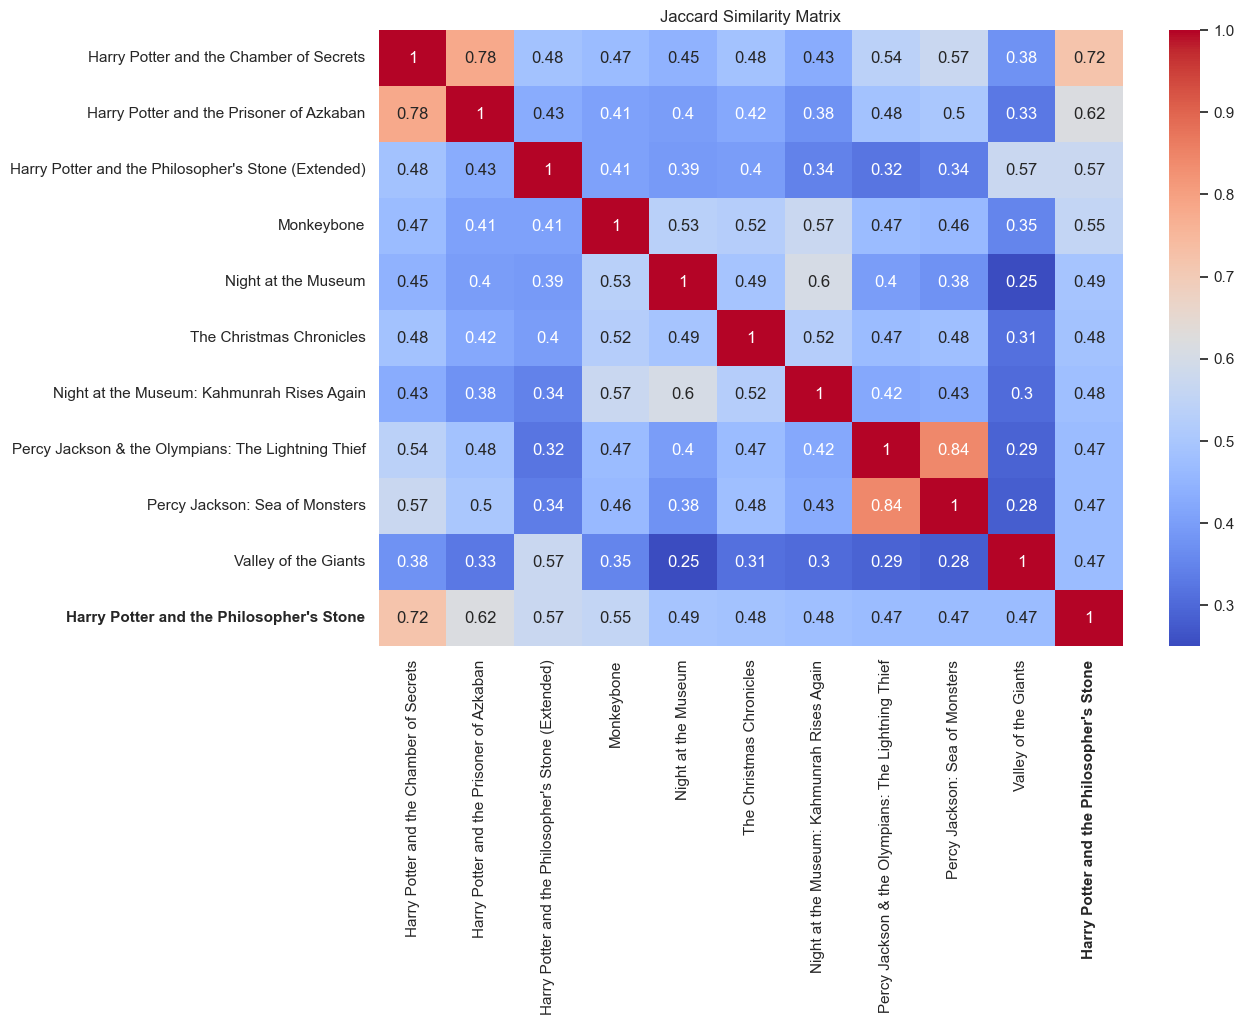

In [31]:
# Calculate the Jaccard similarity matrix
jaccard_similarity_matrix = f.calculate_jaccard_similarity_matrix(top_10_df)

# Create a heatmap with movie titles
plt.figure(figsize=(12, 8))
sns.heatmap(jaccard_similarity_matrix, annot=True, cmap='coolwarm', xticklabels=top_10_df['title'], yticklabels=top_10_df['title'])
plt.title('Jaccard Similarity Matrix')
# plt.xlabel('Movies')
# plt.ylabel('Movies')
# Get the current axes
ax = plt.gca()

# Get the x and y labels
xticklabels = ax.get_xticklabels()
yticklabels = ax.get_yticklabels()

# Make the "Harry Potter and the Philosopher's Stone" label bold on both x and y axis
for i, label in enumerate(xticklabels):
    if label.get_text() == movie_title:
        label.set_fontweight('bold')

for i, label in enumerate(yticklabels):
    if label.get_text() == movie_title:
        label.set_fontweight('bold')

# Apply the updated labels
ax.set_xticklabels(xticklabels)
ax.set_yticklabels(yticklabels)

plt.show()

Before proceeding with the final display of the results we will apply clustering to the whole movie dataset. Thanks to it we will be able to classify all the movies and its recommendation in different groups depending on their *imdb_rating* and *imdb_votes*.

## Clustering

First, we will proceed by changing the nan values to zeros.

In [33]:
# convert to 0 all nan values in the column imdb_votes
main_complete['imdb_votes'] = main_complete['imdb_votes'].fillna(0)

# convert to 0 all nan values in the column imdb_rating
main_complete['imdb_rating'] = main_complete['imdb_rating'].fillna(0)

We will try different clustering mechanisms: K-means clustering, DBSCAN and Heriarchical Clustering.

### K-means clustering

In [34]:
warnings.filterwarnings("ignore", category=UserWarning, module='pandas')

# Select the features ('imdb_rating' and 'imdb_votes')
features = main_complete[['imdb_rating', 'imdb_votes']]

# Separate "Unseen Titles" (movies with 0 votes and 0 ratings)
unseen_titles = main_complete[(main_complete['imdb_rating'] == 0) & (main_complete['imdb_votes'] == 0)]
cluster_data = main_complete[(main_complete['imdb_rating'] != 0) | (main_complete['imdb_votes'] != 0)]

# Standardize the features for clustering
features_to_cluster = cluster_data[['imdb_rating', 'imdb_votes']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_cluster)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
cluster_data['cluster'] = kmeans.fit_predict(scaled_features)

# Compute Davies-Bouldin Index
dbi_score = davies_bouldin_score(scaled_features, cluster_data['cluster'])
print(f"Davies-Bouldin Index: {dbi_score}")

# Assign "Unseen Titles" a new cluster label
unseen_titles['cluster'] = 3  # Assign a distinct cluster label for unseen titles

# Combine all data
result_data = pd.concat([cluster_data, unseen_titles], axis=0)

# Save results to CSV with only title and cluster
result_data[['title', 'cluster', 'Netflix',	'Amazon', 'Hulu', 'Apple', 'HBO']].to_csv('movies_with_clusters.csv', index=False)
print("CSV with movie titles and clustering results saved successfully.")

/var/folders/45/_g835zvx6t3bqdvj9qw669qr0000gn/T/ipykernel_13443/3256967919.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data['cluster'] = kmeans.fit_predict(scaled_features)
/var/folders/45/_g835zvx6t3bqdvj9qw669qr0000gn/T/ipykernel_13443/3256967919.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unseen_titles['cluster'] = 3  # Assign a distinct cluster label for unseen titles


Davies-Bouldin Index: 0.5856433497128725
CSV with movie titles and clustering results saved successfully.


We will know visualize and define the clusters titles.

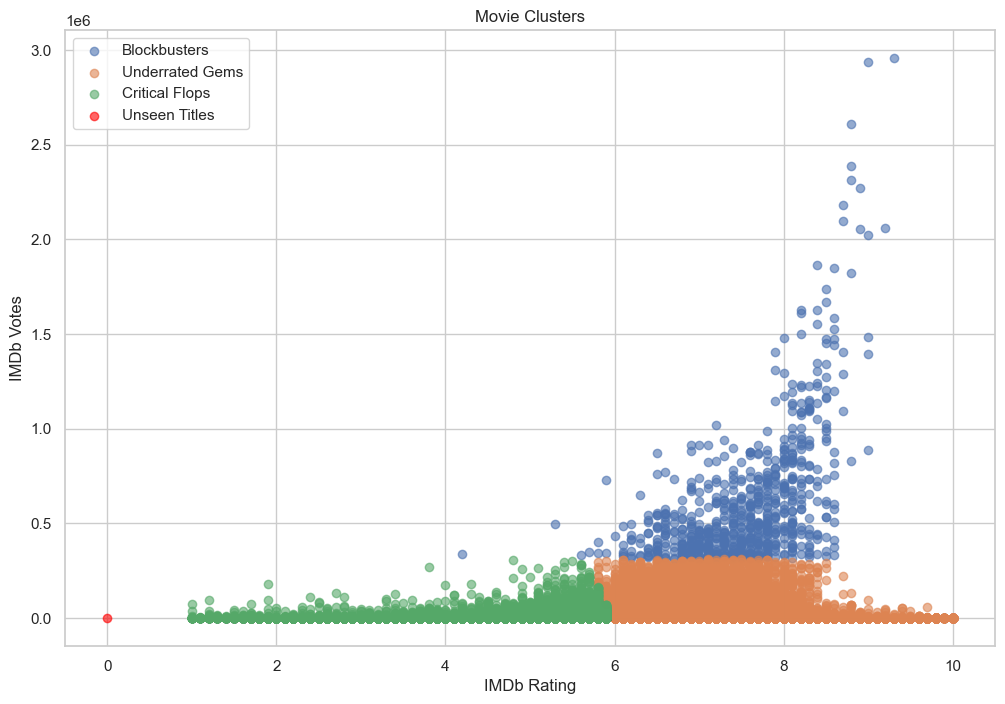

In [35]:
# Define cluster titles
cluster_titles = {
    2: 'Blockbusters',
    0: 'Underrated Gems',
    1: 'Critical Flops',
    3: 'Unseen Titles'
}

clustered_movies = cluster_data.copy()  # Movies used in k-means clustering
unseen_movies = unseen_titles.copy()    # Movies with 0 votes and 0 ratings

# Plot clustered movies
plt.figure(figsize=(12, 8))

# Plot each cluster
for cluster, title in cluster_titles.items():
    if cluster != 3:
        cluster_subset = clustered_movies[clustered_movies['cluster'] == cluster]
        plt.scatter(cluster_subset['imdb_rating'], cluster_subset['imdb_votes'], 
                    label=title, alpha=0.6)

# Plot "Unseen Titles"
plt.scatter(0, 0, c='red', label=cluster_titles[3],  alpha=0.6)


plt.title('Movie Clusters')
plt.xlabel('IMDb Rating')
plt.ylabel('IMDb Votes')
plt.legend(loc='upper left', frameon=True)
plt.grid(True)


plt.show()

**NOTE:** The classes are defined depending on the imdb votes and rating information.
We decided to split them in four classes:
- *Blockbusters:* Movies representing movies with high ratings and a substantial number of votes, indicating crowd-favorites and highly popular.
- *Underrated:* Movies with high ratings but fewer votes, indicating quality content that has not reached a wide audience yet.
- *Critical flops:* Movies with low ratings and minimal engagement, suggesting a lack of both quality and audience interest.
- *Unseen titles:* Movies that have received no ratings and no votes, indicating they have yet to reach an audience or gain visibility.

### DBSCAN

Davies-Bouldin Index: 1.2811780537784005


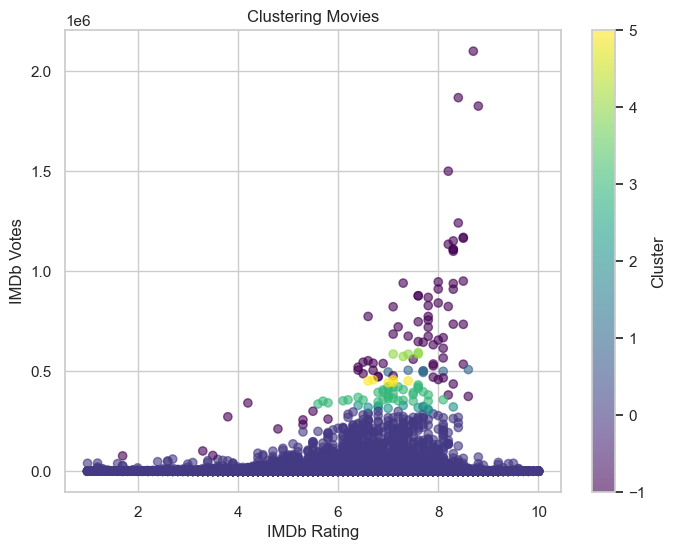

In [36]:
# Sample the data
sample_data = cluster_data.sample(frac=0.2, random_state=42)

# Standardize the features for clustering
features_to_cluster = sample_data[['imdb_rating', 'imdb_votes']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_cluster)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5) 
sample_data['cluster'] = dbscan.fit_predict(scaled_features)

# Compute Davies-Bouldin Index
dbi_score = davies_bouldin_score(scaled_features, sample_data['cluster'])
print(f"Davies-Bouldin Index: {dbi_score}")

# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(sample_data['imdb_rating'], sample_data['imdb_votes'], 
                       c=sample_data['cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title('Clustering Movies')
plt.xlabel('IMDb Rating')
plt.ylabel('IMDb Votes')
plt.grid(True)
plt.show()

### Heriarchical Clustering

Davies-Bouldin Index: 0.6422698545717759


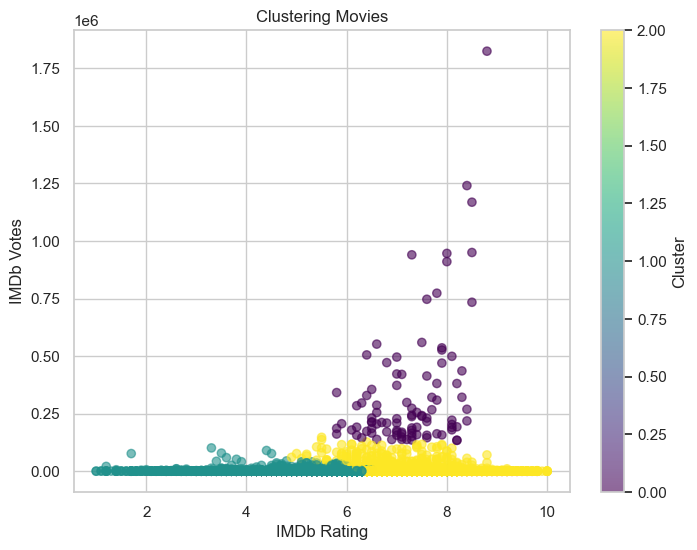

In [37]:
# Sample the data
sample_data = cluster_data.sample(frac=0.05, random_state=42)

# Standardize the features for clustering
features_to_cluster = sample_data[['imdb_rating', 'imdb_votes']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features_to_cluster)

# Apply Hierarchical Clustering using Agglomerative Clustering
agg_clust = AgglomerativeClustering(n_clusters=3) 
sample_data['cluster'] = agg_clust.fit_predict(scaled_features)

# Compute Davies-Bouldin Index
dbi_score = davies_bouldin_score(scaled_features, sample_data['cluster'])
print(f"Davies-Bouldin Index: {dbi_score}")

# Plot the results
plt.figure(figsize=(8, 6))
scatter = plt.scatter(sample_data['imdb_rating'], sample_data['imdb_votes'], 
                       c=sample_data['cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.title('Clustering Movies')
plt.xlabel('IMDb Rating')
plt.ylabel('IMDb Votes')
plt.grid(True)
plt.show()

We decided to use the result of the K-means clustering because ...

We have stored the results of the clustering to be able to easily use them to display the recommendation results.

## Display of the results

We will know display the recommendation results classifying them in the different groups defied thanks to the clustering algorithm.

In [38]:
movies_with_clusters = pd.read_csv('data/movies_with_clusters.csv')
movies_with_clusters.head()

,title,cluster,Netflix,Amazon,Hulu,Apple,HBO
0,Ariel,0,0.0,1.0,1.0,0.0,0.0
1,Shadows in Paradise,0,0.0,1.0,1.0,0.0,0.0
2,Four Rooms,0,0.0,1.0,0.0,1.0,0.0
3,Judgment Night,0,0.0,1.0,0.0,0.0,0.0
4,Life in Loops (A Megacities RMX),0,0.0,0.0,0.0,0.0,0.0


In [39]:
movie_list = top_10_df['title'].tolist()

In [41]:
# Get the list of movie titles
movie_list = top_10_df['title'].tolist()

# Filter movies based on the list
filtered_movies = movies_with_clusters[movies_with_clusters['title'].isin(movie_list)]

In [42]:
if filtered_movies.empty:
    print("No movies found in the filtered list. Please check the movie titles or data consistency.")
else:
    # Define cluster labels
    cluster_labels = {
        2: 'Blockbusters',
        0: 'Underrated Gems',
        1: 'Critical Flops',
        3: 'Unseen Titles'
    }

    # Map the cluster numbers to descriptive labels
    filtered_movies = filtered_movies.copy()
    filtered_movies['cluster'] = filtered_movies['cluster'].map(cluster_labels)

    # Define platform columns
    platform_columns = ['Netflix', 'Amazon', 'Hulu', 'Apple', 'HBO']

    # Create 'In Platforms' column listing all platforms where the movie is available
    filtered_movies['In Platforms'] = filtered_movies[platform_columns] \
        .apply(lambda row: ', '.join([platform for platform in platform_columns if row[platform] == 1.0]) 
               if any(row[platform] == 1.0 for platform in platform_columns) else 'Not available', axis=1)

    # Separate and print movies by clusters
    for cluster_name in cluster_labels.values():
        print(f"Movies in {cluster_name}:")
        cluster_movies = filtered_movies[filtered_movies['cluster'] == cluster_name]
        if cluster_movies.empty:
            print("No movies in this cluster.")
        else:
            print(cluster_movies[['title', 'In Platforms']])

Movies in Blockbusters:
                                         title                In Platforms
539   Harry Potter and the Philosopher's Stone               Not available
540    Harry Potter and the Chamber of Secrets  Netflix, Amazon, Hulu, HBO
541   Harry Potter and the Prisoner of Azkaban  Netflix, Amazon, Hulu, HBO
1039                       Night at the Museum                        Hulu
Movies in Underrated Gems:
                                                    title     In Platforms
19727   Percy Jackson & the Olympians: The Lightning T...  Netflix, Amazon
92751                                Valley of the Giants    Not available
260237                           The Christmas Chronicles          Netflix
Movies in Critical Flops:
                                             title     In Platforms
13616                                   Monkeybone    Not available
49212               Percy Jackson: Sea of Monsters  Netflix, Amazon
328213  Night at the Museum: Kahmunrah Rises

Here is the final representation of the results:

In [45]:
from tabulate import tabulate

# Separate and print movies by clusters
for cluster_name in cluster_labels.values():
    print(f"\n{cluster_name}:\n")
    cluster_movies = filtered_movies[filtered_movies['cluster'] == cluster_name]
    if cluster_movies.empty:
        print("No movies in this cluster.")
    else:
        # Format the DataFrame into a table using tabulate
        print(tabulate(cluster_movies[['title', 'In Platforms']], headers='keys', tablefmt='pretty'))


Blockbusters:

+------+------------------------------------------+----------------------------+
|      |                  title                   |        In Platforms        |
+------+------------------------------------------+----------------------------+
| 539  | Harry Potter and the Philosopher's Stone |       Not available        |
| 540  | Harry Potter and the Chamber of Secrets  | Netflix, Amazon, Hulu, HBO |
| 541  | Harry Potter and the Prisoner of Azkaban | Netflix, Amazon, Hulu, HBO |
| 1039 |           Night at the Museum            |            Hulu            |
+------+------------------------------------------+----------------------------+

Underrated Gems:

+--------+----------------------------------------------------+-----------------+
|        |                       title                        |  In Platforms   |
+--------+----------------------------------------------------+-----------------+
| 19727  | Percy Jackson & the Olympians: The Lightning Thief | Netflix